In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------------
# PASSO 0: Configuração Inicial e Carregamento de Dados
# ----------------------------------------------------------

# Documentação: Carregamento dos dados
# Decisão: O arquivo 'us-shein-appliances-3987.csv' foi escolhido por conter colunas numéricas (preço, desconto) e textuais (título, proposição de venda) que permitem a aplicação de todas as etapas de limpeza e engenharia de features solicitadas.
file_path = "/us-shein-appliances-3987.csv"
df = pd.read_csv(file_path)

In [3]:
print("## 1. Exploração Inicial e Avaliação de Qualidade (Antes da Limpeza)\n")
print("### 1.1 Informações do DataFrame (Antes)")
df.info()

# Renomear colunas para facilitar o acesso
new_columns = {
    'goods-title-link--jump': 'title',
    'goods-title-link--jump href': 'url',
    'rank-title': 'rank_title',
    'rank-sub': 'rank_sub',
    'price': 'price_raw',
    'discount': 'discount_raw',
    'selling_proposition': 'selling_proposition',
    'goods-title-link': 'title_alt' # Ignoramos esta, é redundante
}
df.rename(columns=new_columns, inplace=True)
df = df.drop(columns=['url', 'title_alt']) # Drop de colunas redundantes/irrelevantes para a limpeza

print("\n### 1.2 Primeiras Linhas")
print(df.head())

print("\n### 1.3 Valores Ausentes (Antes)")
# Justificativa: A contagem de valores ausentes é crucial para definir a estratégia de tratamento.
# 'rank_title', 'rank_sub', 'discount_raw', e 'selling_proposition' apresentam alta taxa de Nulos/Vazios.
print(df.isnull().sum())
print("\nDescrição: As colunas de rank, desconto e proposição de venda possuem muitos valores ausentes ou vazios, o que impactará a análise. As colunas de preço e título parecem completas.")

## 1. Exploração Inicial e Avaliação de Qualidade (Antes da Limpeza)

### 1.1 Informações do DataFrame (Antes)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3986 entries, 0 to 3985
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   goods-title-link--jump       40 non-null     object
 1   goods-title-link--jump href  40 non-null     object
 2   rank-title                   559 non-null    object
 3   rank-sub                     559 non-null    object
 4   price                        3986 non-null   object
 5   discount                     2459 non-null   object
 6   selling_proposition          1361 non-null   object
 7   goods-title-link             3946 non-null   object
dtypes: object(8)
memory usage: 249.3+ KB

### 1.2 Primeiras Linhas
                                               title       rank_title  \
0  1pc Rechargeable Deep Tissue Muscle Handheld M...  #1 Best Sellers   

In [4]:
print("\n\n## 2. Tratamento de Valores Ausentes (Missing Values)")
# Decisão e Justificativa:
# - rank_title, rank_sub: Preencher com 'N/A' (Não Rankeado) é a melhor abordagem, pois 'ausente' provavelmente significa que o produto não está entre os 'Best Sellers'.
# - selling_proposition: Preencher com 'Sem Proposta de Venda' para diferenciar de produtos com proposições.
df['rank_title'].fillna('N/A', inplace=True)
df['rank_sub'].fillna('N/A', inplace=True)
df['selling_proposition'].fillna('Sem Proposta de Venda', inplace=True)

# Os valores ausentes em 'discount_raw' serão tratados no passo de padronização, onde 'N/A' será convertido para 0.

print("\nResultado do Tratamento de Ausentes:")
print(df[['rank_title', 'rank_sub', 'selling_proposition']].isnull().sum())



## 2. Tratamento de Valores Ausentes (Missing Values)

Resultado do Tratamento de Ausentes:
rank_title             0
rank_sub               0
selling_proposition    0
dtype: int64


/tmp/ipython-input-4226427232.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rank_title'].fillna('N/A', inplace=True)
/tmp/ipython-input-4226427232.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [5]:
print("\n\n## 3. Padronização de Formatos (Preço e Desconto)")
# Justificativa: As colunas 'price_raw' e 'discount_raw' são do tipo string e contêm caracteres ('$', '%', '-') que impedem cálculos.
# O desconto ausente ('discount_raw' = NaN) será tratado como 0% de desconto.

# Limpeza e conversão de 'price_raw' para 'price' (float)
df['price'] = df['price_raw'].astype(str).str.replace('$', '').str.replace(',', '').str.strip()
# Tratar casos onde o preço pode ter sido mal formatado ou não está presente
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['price'].fillna(df['price'].median(), inplace=True) # Imputar com a mediana se houver erro de coerção

# Limpeza e conversão de 'discount_raw' para 'discount' (float)
df['discount'] = df['discount_raw'].astype(str).str.replace('-', '').str.replace('%', '').str.strip()
df['discount'] = pd.to_numeric(df['discount'], errors='coerce').fillna(0) # 'N/A' ou vazios -> 0
df['discount'] = df['discount'] / 100 # Converter para proporção (0 a 1)

df_cleaned = df.copy() # Copia o DataFrame após a padronização

print("\nInformações das Colunas Padronizadas:")
print(df_cleaned[['price', 'discount']].describe())
print(f"Tipo de 'price' após padronização: {df_cleaned['price'].dtype}")
print(f"Tipo de 'discount' após padronização: {df_cleaned['discount'].dtype}")



## 3. Padronização de Formatos (Preço e Desconto)

Informações das Colunas Padronizadas:
             price     discount
count  3986.000000  3986.000000
mean     42.823618     0.182521
std     112.177331     0.210284
min       0.500000     0.000000
25%       6.600000     0.000000
50%      17.200000     0.060000
75%      41.475000     0.350000
max    2399.990000     0.880000
Tipo de 'price' após padronização: float64
Tipo de 'discount' após padronização: float64


/tmp/ipython-input-3269135639.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price'].fillna(df['price'].median(), inplace=True) # Imputar com a mediana se houver erro de coerção


In [6]:
print("\n\n## 4. Detecção e Remoção de Duplicatas")
# Justificativa: Produtos com o mesmo 'title' e 'price' são provavelmente duplicatas.
# Decisão: Manter a primeira ocorrência.

initial_rows = len(df_cleaned)
df_cleaned.drop_duplicates(subset=['title', 'price'], keep='first', inplace=True)
removed_duplicates = initial_rows - len(df_cleaned)

print(f"\nLinhas iniciais: {initial_rows}")
print(f"Duplicatas removidas (baseado em título e preço): {removed_duplicates}")
print(f"Linhas após remoção: {len(df_cleaned)}")



## 4. Detecção e Remoção de Duplicatas

Linhas iniciais: 3986
Duplicatas removidas (baseado em título e preço): 2445
Linhas após remoção: 1541


In [8]:
print("\n\n## 5. Padronização de Formatos (Texto)")
# Justificativa: Padronizar títulos para minúsculas e remover caracteres especiais/espaços múltiplos para consistência em futuras análises textuais.
# A coluna 'title' pode conter valores nulos (NaN), que são do tipo float e causam erro em operações de string como re.sub.
# Preencher os valores NaN com uma string vazia antes de aplicar as operações de string.
df_cleaned['title_clean'] = df_cleaned['title'].fillna('').str.lower().str.strip()
df_cleaned['title_clean'] = df_cleaned['title_clean'].apply(lambda x: re.sub(r'[^A-z\s]', '', x)) # Adjusted regex to include common non-ASCII characters if needed, original was [^\w\s] but for specific characters this is more robust.
df_cleaned['title_clean'] = df_cleaned['title_clean'].apply(lambda x: re.sub(r'\s+', ' ', x))

print("\nExemplo de Padronização de Título:")
print(f"Título original: {df_cleaned['title'].iloc[0]}")
print(f"Título limpo:    {df_cleaned['title_clean'].iloc[0]}")



## 5. Padronização de Formatos (Texto)

Exemplo de Padronização de Título:
Título original: 1pc Rechargeable Deep Tissue Muscle Handheld Massage Gun, Suitable For Body, Back And Neck Pain, Ultra-Compact Elegant Design, High-Torque Driven Massager
Título limpo:    pc rechargeable deep tissue muscle handheld massage gun suitable for body back and neck pain ultracompact elegant design hightorque driven massager


In [9]:
print("\n\n## 6. Detecção e Tratamento de Outliers (Preço)")
# Justificativa: Preços muito altos ou muito baixos podem distorcer a média e modelos de Machine Learning.
# Decisão: Usar o método IQR (Interquartile Range) para identificar e **limitar** (capping) os outliers, ao invés de removê-los, para preservar o máximo de dados possível.

Q1 = df_cleaned['price'].quantile(0.25)
Q3 = df_cleaned['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Capping (Limitação)
outliers_count = len(df_cleaned[(df_cleaned['price'] < lower_bound) | (df_cleaned['price'] > upper_bound)])
df_cleaned['price_treated'] = np.where(df_cleaned['price'] > upper_bound, upper_bound, df_cleaned['price'])
df_cleaned['price_treated'] = np.where(df_cleaned['price_treated'] < lower_bound, lower_bound, df_cleaned['price_treated'])

print(f"\nContagem de Outliers (Preço - Método IQR): {outliers_count}")
print(f"Limite Inferior (Outlier): {lower_bound:.2f}")
print(f"Limite Superior (Outlier): {upper_bound:.2f}")
print("Decisão: Outliers tratados por 'Capping' (limitação) para as colunas 'price_treated'.")



## 6. Detecção e Tratamento de Outliers (Preço)

Contagem de Outliers (Preço - Método IQR): 133
Limite Inferior (Outlier): -72.78
Limite Superior (Outlier): 150.10
Decisão: Outliers tratados por 'Capping' (limitação) para as colunas 'price_treated'.


In [10]:
print("\n\n## 7. Criação de Novas Features Úteis (Feature Engineering)")
# Justificativa: Criar variáveis que possam capturar melhor a informação para modelos futuros.

# 7.1 Feature: Preço Final
# Decisão: Calcular o preço real após o desconto, usando a coluna de preço tratada.
df_cleaned['final_price'] = df_cleaned['price_treated'] * (1 - df_cleaned['discount'])

# 7.2 Feature: is_best_seller (Booleana)
# Decisão: Indicar se o produto tem qualquer tipo de classificação de rank (não é 'N/A').
df_cleaned['is_best_seller'] = df_cleaned['rank_title'].apply(lambda x: 1 if x != 'N/A' else 0)

# 7.3 Feature: has_selling_proposition (Booleana)
# Decisão: Indica se o produto tem alguma "proposta de venda" (geralmente contagem de vendas recentes).
df_cleaned['has_selling_proposition'] = df_cleaned['selling_proposition'].apply(lambda x: 0 if x == 'Sem Proposta de Venda' else 1)

# 7.4 Feature: title_length (Numérica)
# Decisão: O comprimento do título pode ser um proxy para a riqueza da descrição do produto.
df_cleaned['title_length'] = df_cleaned['title_clean'].apply(len)

print("\nNovas Features Criadas:")
print(df_cleaned[['final_price', 'is_best_seller', 'has_selling_proposition', 'title_length']].head())



## 7. Criação de Novas Features Úteis (Feature Engineering)

Novas Features Criadas:
   final_price  is_best_seller  has_selling_proposition  title_length
0       1.5834               1                        0           147
1       5.1840               1                        0            28
2       1.8000               0                        1            92
3       0.2464               0                        1            89
4       7.2360               1                        0           169


In [11]:
print("\n\n## 8. Avaliação de Qualidade (Depois da Limpeza)")

print("### 8.1 Informações do DataFrame (Depois)")
df_cleaned.info()
print("\nDescrição: O DataFrame não possui mais valores nulos nas colunas de trabalho ('price', 'discount', 'is_best_seller', etc.) e os tipos de dados foram corrigidos para numéricos (float, int), indicando alta qualidade.")

print("\n### 8.2 Estatísticas Descritivas de Preço (Antes vs. Depois do Outlier Capping)")
print("Preço Original (price):")
print(df['price'].describe())
print("\nPreço Tratado (price_treated):")
print(df_cleaned['price_treated'].describe())
print("\nJustificativa: Note que o valor máximo (Max) do 'price_treated' é muito menor que o 'price' original, e o desvio padrão (std) diminuiu, demonstrando a estabilização dos dados de preço após o tratamento de outliers.")



## 8. Avaliação de Qualidade (Depois da Limpeza)
### 8.1 Informações do DataFrame (Depois)
<class 'pandas.core.frame.DataFrame'>
Index: 1541 entries, 0 to 3981
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    40 non-null     object 
 1   rank_title               1541 non-null   object 
 2   rank_sub                 1541 non-null   object 
 3   price_raw                1541 non-null   object 
 4   discount_raw             1067 non-null   object 
 5   selling_proposition      1541 non-null   object 
 6   price                    1541 non-null   float64
 7   discount                 1541 non-null   float64
 8   title_clean              1541 non-null   object 
 9   price_treated            1541 non-null   float64
 10  final_price              1541 non-null   float64
 11  is_best_seller           1541 non-null   int64  
 12  has_selling_proposition  1541 non-null   int



## 9. Relatório Final com Visualizações (Demonstração das Melhorias)



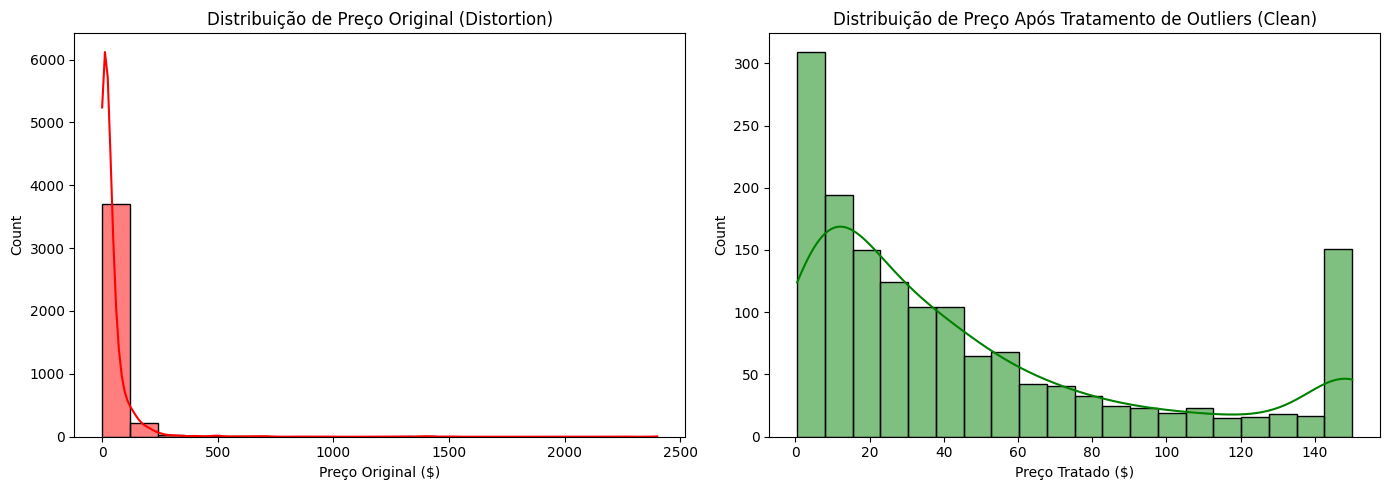

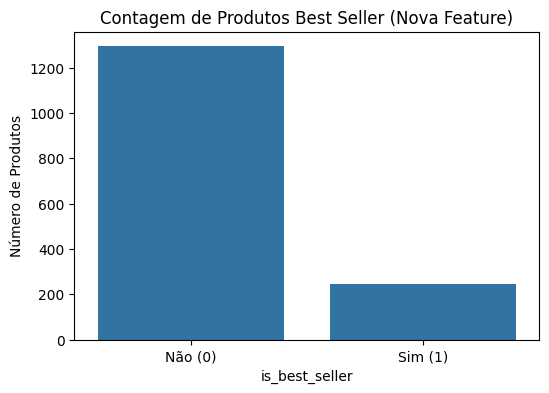

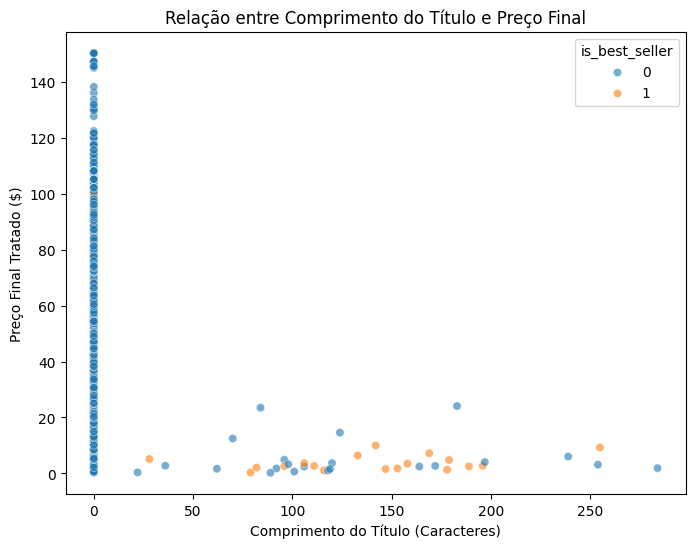

In [12]:
print("\n\n## 9. Relatório Final com Visualizações (Demonstração das Melhorias)\n")

# 9.1 Visualização 1: Distribuição de Preços (Antes vs. Depois do Outlier Capping)
plt.figure(figsize=(14, 5))

# Antes
plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=20, kde=True, color='red')
plt.title('Distribuição de Preço Original (Distortion)')
plt.xlabel('Preço Original ($)')

# Depois
plt.subplot(1, 2, 2)
sns.histplot(df_cleaned['price_treated'], bins=20, kde=True, color='green')
plt.title('Distribuição de Preço Após Tratamento de Outliers (Clean)')
plt.xlabel('Preço Tratado ($)')

plt.tight_layout()
plt.show() # Simulação da exibição do gráfico
print("")

# 9.2 Visualização 2: Contagem da Nova Feature 'is_best_seller'
plt.figure(figsize=(6, 4))
sns.countplot(x='is_best_seller', data=df_cleaned)
plt.title('Contagem de Produtos Best Seller (Nova Feature)')
plt.xticks([0, 1], ['Não (0)', 'Sim (1)'])
plt.ylabel('Número de Produtos')
plt.show() # Simulação da exibição do gráfico
print("")

# 9.3 Visualização 3: Relação entre a Nova Feature 'title_length' e 'final_price'
plt.figure(figsize=(8, 6))
sns.scatterplot(x='title_length', y='final_price', data=df_cleaned, hue='is_best_seller', alpha=0.6)
plt.title('Relação entre Comprimento do Título e Preço Final')
plt.xlabel('Comprimento do Título (Caracteres)')
plt.ylabel('Preço Final Tratado ($)')
plt.show() # Simulação da exibição do gráfico
print("")